**Feito pelo Grupo W:
Leonardo Groot;
Arthur Bonamigo;
João Muller;
Pedro Vincente.**

#**System Definition**

Observation: attending to many references, Ld was assumed equal to Lq (simetric generator). This leads to a huge simplification as it will be further seen.

**State Variables:**

x1 = θ (Rotor rotation - Generator rotation)[rad]

x2 = ωr (Rotor angular speed) [rad/s]

x3 = ωg (Generator angular speed) [rad/s]

x4 = Id (Direct circuit current) [A]

x5 = Iq (Quadrature circuit current) [A]

**Input Variables:**

u1 = vw (wind speed) [m/s]

u2 = β (pitch angle) [deg]

**Output Variables:**

y1 = Ta (aerodynamic torque) [Nm]

y2 = Tg (generator torque) [Nm]

y3 = ωr (rotor angular speed) [rad/s]

y4 = ωg (generator angular speed) [rad/s]

y5 = Id (Direct circuit current) [A]

y6 = Iq (Quadrature circuit current) [A]

y7 = Pg (Generated power) [W]

Por favor instale as bibliotecas: Sympy, matplotlib.pyplot, numpy, control e tbcontrol

In [ ]:
!pip install control
!pip install tbcontrol
#!pip install slycot biblioteca difícil de instalar, outputs serão colocados como imagens, se quiser tentar instalar: boa sorte

In [ ]:
import sympy as sp
from sympy import *
from sympy.physics.mechanics import *
import sympy.physics.mechanics.system as system
from sympy.physics.vector import *
init_vprinting(use_unicode = True)
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from tbcontrol.symbolic import routh

In [ ]:
# Input variables
vw, beta = symbols('vw beta')
u = [vw, beta]

# Parameters
Jr, Jg, ks, b, Ld, Lq, Rs, n_p, psi, b, bb, Ud, Uq= symbols('Jr Jg ks b Ld Lq Rs np psi b bb Ud Uq')
rho, area, radius = symbols('rho A r')


# State variables and derivatives
x1, x2, x3, x4, x5 = dynamicsymbols('x1 x2 x3 x4 x5')
x1d, x2d, x3d, x4d, x5d = dynamicsymbols("x1 x2 x3 x4 x5", 1)
x = [x1, x2, x3, x4, x5] # State vector
xd = [x1d, x2d, x3d, x4d, x5d] # derivative of state vector


# Output variables
Tm, Tg, Cp, lambdai, lambd, Pe, Pm, P_nom = dynamicsymbols('T_a T_g C_p lambda_i lambda Pe Pa P_nom')

# Wind/Turbine Modeling

area = pi*radius**2

lambd = x2*radius/vw #Tip Speed Ratio

lambdai = 1/(1/(lambd + 0.08*beta) - 0.035/(beta**3 + 1)) # Adimensional Tip Speed Adjustment CHECK

Cp = 0.22*(116/lambdai - 0.4*beta - 5) * 2.718 ** (-12.5/lambdai) # Power Coefficient

Pm = 0.5 * rho * area * Cp * vw ** 3 # Mechanical/Aerodynamic Power

Tm = Pm / x2 # Mechanical/Aerodynamic Torque

# PMSG

p = 2*n_p

we = p * x3 / 2 # Eletrical Angular Velocity

eq1 =  - (x4 * Rs) + (x3 * x5 * p/2 * Lq) - Ud # d Current Equation

eq2 =  - (x5 * Rs) - (x3 * x4 * p/2 * Ld) + (x3 * p/2 * psi) - Uq # q Current Equation

Te = 3/4 * p * psi * x5 # Eletromagnetic Torque

# Drive Train Modeling

eq3 = b*(x2-x3) + ks*x1 - Tm #   First Mechanical Equation --- Rotor Dynamics

eq4 = b*(x3-x2) + ks*-x1 + Te #  Second Mechanical Equation --- Generator Dynamics

Pe = Ud * x4 + Uq * x5

y1, y2, y3, y4, y5, y6, y7= dynamicsymbols("y1 y2 y3 y4 y5 y6 y7")
[y1, y2, y3,y4, y5, y6, y7] = [Tm, Te, x3, x4, x5, Pe, P_nom]
y = Matrix([y1, y2, y3, y4, y5, y6, y7]) # output vector


# State function
f_not_linear = Matrix(5,1, [x2 - x3,
                            -(b*(x2-x3) + ks*x1 + Tm)/Jr,
                            -(b*(x3-x2) + ks*-x1 - Te)/Jg,
                            (- (x4 * Rs) + (x3 * x5 * p/2 * Lq) - Ud)/Ld,
                            (- (x5 * Rs) - (x3 * x4 * p/2 * Ld) + (x3 * p/2 * psi) - Uq)/Lq])



**Generic Space State model**

In [ ]:
f_not_linear

⎡                                                  x₂ - x₃                    
⎢                                                                             
⎢           0.4375        12.5                                                
⎢           ────── - ─────────────                                            
⎢            3                r⋅x₂                                            
⎢           β  + 1   0.08⋅β + ────                                            
⎢                              vw     2     3 ⎛                 0.8932       2
⎢  0.5⋅2.718                      ⋅π⋅r ⋅ρ⋅vw ⋅⎜-0.088⋅β - 1.1 - ────── + ─────
⎢                                             ⎜                  3            
⎢                                             ⎜                 β  + 1   0.08⋅
⎢                                             ⎝                               
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                           x₂      

**Numerical Parameters**

In [ ]:
numerical_parameters = [(beta, 0), (radius, 63), (Jr, 5 * 10e6), (Jg, 0.1 * 10e6),
                        (rho, 1.2), (Rs, 0.0034), (Ld, 0.00063), (Lq, 0.00063),
                        (n_p, 48) , (ks, 30 * 10e7), (b, 13 * 10e6), (psi, 28.6/6.5),
                        (Ud, 690), (Uq, 0), (pi, np.pi)]

# beta = 0 -- Lyapunov stability of grid-connected wind turbines with permanent magnet synchronous generator
# radius = 63
# Jr = 4.8 * 10e6
# Jg = 0.3 * 10e6
# Rs = 0.034
# Ld and Lq = 0.00063
# n_p = 48
# Ud = 690
# Uq = 0
# ks = 30 * 10e7 AJUSTADO -- (GABRIEL MODUKPE; DON DIEI, 2020)
# b = 13 * 10e6 AJUSTADO -- (GABRIEL MODUKPE; DON DIEI, 2020)
# Rho = 1.2 -- An MPPT Strategy for Wind Turbines Combining Feedback Linearization and Model Predictive Control
# psi = 28.6/6.5 AJUSTADO -- Permanent Magnet Synchronous Generator forOffshore Wind Energy System Connected to Gridand Battery-Modeling and Control Strategies


**Specific Space State model**

In [ ]:
paramsdict = {radius: 63, Jr: 5 * 10e6, Jg: 0.1 * 10e6,
                        rho: 1.2, Rs: 0.0034, Ld: 0.00063, Lq: 0.00063,
                        n_p: 48 , ks: 30 * 10e7, b: 13 * 10e6, psi: 28.6/6.5,
                        Ud: 690, Uq: 0, pi: np.pi}

In [ ]:
def state(t,x,u, params = paramsdict):
    return [x[1] - x[2],
            (-0.5*2.718**(0.4375/(u[1]**3 + 1) - 12.5/(0.08*u[1] + paramsdict[radius]*x[1]/u[0]))*paramsdict[pi]*paramsdict[radius]**2*paramsdict[rho]*u[0]**3*(-0.088*u[1] - 1.1 - 0.8932/(u[1]**3 + 1) + 25.52/(0.08*u[1] + paramsdict[radius]*x[1]/u[0]))/x[1] - paramsdict[b]*(x[1] - x[2]) - paramsdict[ks]*x[0])/paramsdict[Jr],
            (-paramsdict[b]*(-x[1] + x[2]) - paramsdict[ks]*-x[0] + 1.5*paramsdict[n_p]*paramsdict[psi]*x[4])/paramsdict[Jg],
            (paramsdict[Lq]*paramsdict[n_p]*x[2]*x[4] - paramsdict[Rs]*x[3] - paramsdict[Ud])/paramsdict[Ld],
            (-paramsdict[Ld]*paramsdict[n_p]*x[2]*x[3] - paramsdict[Rs]*x[4] - paramsdict[Uq] + paramsdict[n_p]*paramsdict[psi]*x[2])/paramsdict[Lq]]

def output(t,x,u, params = paramsdict):
    return [
        0.5*2.718**(0.4375/(u[1]**3 + 1) - 12.5/(0.08*u[1] + paramsdict[radius]*x[1]/u[0]))*paramsdict[pi]*paramsdict[radius]**2*paramsdict[rho]*u[0]**3*(-0.088*u[1] - 1.1 - 0.8932/(u[1]**3 + 1) + 25.52/(0.08*u[1] + paramsdict[radius]*x[1]/u[0]))/x[1],
        3/2 * paramsdict[n_p] * paramsdict[psi] * x[4],
        x[1],
        x[2],
        x[3],
        x[4],
        paramsdict[Ud] * x[3] + paramsdict[Uq] * x[4]
    ]

In [ ]:
nonl_sys = ct.NonlinearIOSystem(
    updfcn = state,
    outfcn = output,
    inputs = ['v_wind','pitch_angle'],
    outputs = ["y1","y2","y3","y4","y5","y6","y7"],
    states = ['x1', 'x2', 'x3', 'x4', 'x5'], name='Not_Linear_Turbine')

In [ ]:
X0 = np.array([-0.00243108882939462, 1.01257816695318, 1.01257816695318, 4426.69445129161, 23026.566513702])

**Operation point determination**

In [ ]:
xp = ct.find_eqpt(nonl_sys,x0 = X0, u0 = [14,0])[0]
print(xp)

[-2.43086363e-03  1.01285277e+00  1.01285277e+00  4.42879407e+03
  2.30195419e+04]


In [ ]:
Matrix(state(0,xp,[14,0]))

⎡         0          ⎤
⎢                    ⎥
⎢-1.564621925354e-15 ⎥
⎢                    ⎥
⎢1.86264514923096e-15⎥
⎢                    ⎥
⎢5.41365893912457e-10⎥
⎢                    ⎥
⎣-2.93239859202581e-9⎦

In [ ]:
t = np.linspace(0, 5, 20000)
resp = ct.input_output_response(nonl_sys,t, U = [14,0], X0=xp)

**Sistema Linear**

In [ ]:
linear = ct.linearize(nonl_sys,xeq=xp, ueq = [14,0])

In [ ]:
A, B, C, D = Matrix(linear.A).evalf(6), Matrix(linear.B).evalf(6), Matrix(linear.C).evalf(6), Matrix(linear.D).evalf(6) # truncando o erro numérico

In [ ]:
linsys = ct.StateSpace(A, B, C, D)

In [ ]:
lin = ct.LinearIOSystem(linsys,
                        inputs = ['v_wind','pitch_angle'],
                        outputs = ["y1","y2","y3","y4","y5","y6","y7"],
                        states = ['x1', 'x2', 'x3', 'x4', 'x5'], name='Linear_Turbine')

In [ ]:
A

⎡943093.0  -25713.5⎤
⎢                  ⎥
⎢   0         0    ⎥
⎢                  ⎥
⎢   0         0    ⎥
⎢                  ⎥
⎢   0         0    ⎥
⎢                  ⎥
⎢   0         0    ⎥
⎢                  ⎥
⎢   0         0    ⎥
⎢                  ⎥
⎣   0         0    ⎦

In [ ]:
B

In [ ]:
C

In [ ]:
D

In [ ]:
#truncando o erro da função de tranferência
def aprox(x):
    y = []
    for i in x:
        if abs(i) < 10e-13:
            y.append(0)
        else:
            y.append(i)
    return y

In [ ]:
lin.poles() # polos da função

array([-105.16771208 +0.j        ,   -5.29429406+50.00464837j,
         -5.29429406-50.00464837j,  -27.49995318 +0.j        ,
         -0.16469606 +0.j        ])

In [ ]:
#tf = ct.ss2tf(lin)
# tfs = {"AT": [[ct.TransferFunction(aprox(tf.num[0][0]),aprox(tf.den[0][0])),ct.TransferFunction(aprox(tf.num[0][1]),aprox(tf.den[0][1]))], "Torque Aerodinâmico"],
#        "GT": [[ct.TransferFunction(aprox(tf.num[1][0]),aprox(tf.den[1][0])),ct.TransferFunction(aprox(tf.num[1][1]),aprox(tf.den[1][1]))], "Torque Eletromecânico"],
#        "WR": [[ct.TransferFunction(aprox(tf.num[2][0]),aprox(tf.den[2][0])),ct.TransferFunction(aprox(tf.num[2][1]),aprox(tf.den[2][1]))], "Rotação do Rotor"],
#        "WG": [[ct.TransferFunction(aprox(tf.num[3][0]),aprox(tf.den[3][0])),ct.TransferFunction(aprox(tf.num[3][1]),aprox(tf.den[3][1]))], "Rotação do Gerador"],
#        "ID": [[ct.TransferFunction(aprox(tf.num[4][0]),aprox(tf.den[4][0])),ct.TransferFunction(aprox(tf.num[4][1]),aprox(tf.den[4][1]))], "Corrente Direta"],
#        "IQ": [[ct.TransferFunction(aprox(tf.num[5][0]),aprox(tf.den[5][0])),ct.TransferFunction(aprox(tf.num[5][1]),aprox(tf.den[5][1]))], "Corrente de Quadratura"],
#        "POT":[[ct.TransferFunction(aprox(tf.num[6][0]),aprox(tf.den[6][0])),ct.TransferFunction(aprox(tf.num[6][1]),aprox(tf.den[6][1]))], "Potência gerada"]}
#tf
#Célula que mostra as funções de transferência truncadas

$$\begin{bmatrix}\frac{9.431 \times 10^{5} s^5 + 1.352 \times 10^{8} s^4 + 6.456 \times 10^{9} s^3 + 3.461 \times 10^{11} s^2 + 6.944 \times 10^{12} s + 9.511 \times 10^{11}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}&\frac{-2.571 \times 10^{4} s^5 - 3.687 \times 10^{6} s^4 - 1.76 \times 10^{8} s^3 - 9.437 \times 10^{9} s^2 - 1.893 \times 10^{11} s - 2.593 \times 10^{10}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}\\\frac{-9.528 \times 10^{7} s^2 + 3.902 \times 10^{10} s + 9.511 \times 10^{11}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}&\frac{2.598 \times 10^{6} s^2 - 1.064 \times 10^{9} s - 2.593 \times 10^{10}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}\\\frac{-0.01886 s^4 - 2.656 s^3 - 127.5 s^2 - 6795 s - 1.354 \times 10^{5}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}&\frac{0.0005143 s^4 + 0.07241 s^3 + 3.475 s^2 + 185.3 s + 3692}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}\\\frac{-2.452 s^3 - 83.05 s^2 - 6478 s - 1.354 \times 10^{5}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}&\frac{0.06686 s^3 + 2.264 s^2 + 176.6 s + 3692}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}\\\frac{-1.462 \times 10^{-17} s^3 - 2.709 \times 10^{6} s^2 - 9.177 \times 10^{7} s - 6.749 \times 10^{8}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}&\frac{9.14 \times 10^{-19} s^3 + 7.387 \times 10^{4} s^2 + 2.502 \times 10^{6} s + 1.84 \times 10^{7}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}\\\frac{1.299 \times 10^{-17} s^3 - 3.008 \times 10^{5} s^2 + 1.232 \times 10^{8} s + 3.002 \times 10^{9}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}&\frac{-4.058 \times 10^{-19} s^3 + 8200 s^2 - 3.358 \times 10^{6} s - 8.186 \times 10^{7}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}\\\frac{-1.009 \times 10^{-14} s^3 - 1.869 \times 10^{9} s^2 - 6.332 \times 10^{10} s - 4.657 \times 10^{11}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}&\frac{5.097 \times 10^{7} s^2 + 1.726 \times 10^{9} s + 1.27 \times 10^{10}}{s^5 + 143.4 s^4 + 6849 s^3 + 3.672 \times 10^{5} s^2 + 7.373 \times 10^{6} s + 1.204 \times 10^{6}}\\ \end{bmatrix}$$

In [ ]:
# uuu = ["v_wind (m/s)","pitch_angle (rad)"]
# for i in tfs:
#     for j in range(len(tfs[i][0])):
#         A = ct.bode_plot(tfs[i][0][j],dB = True, omega_limits=[10e-3,10e5])
#         plt.title("Diagrama de Bode: {}".format(tfs[i][1]) + " -- " + uuu[j], y = 2.2)
#         #plt.savefig("Diagrama_de_Bode_{}.png".format(i + uuu[j][0]))
#         plt.figure()

#Função que plota os diagramas de Bode que estão no relatório

In [ ]:
# s, a0, a1, a2, a3, a4, a5 = symbols("s a0 a1 a2 a3 a4 a5")
# ps = poly([a0,a1,a2,a3,a4,a5] @ np.array([s**5,s**4,s**3,s**2,s,1]),s)
# psn = poly(tfs["AT"][0][0].den[0][0] @ np.array([s**5,s**4,s**3,s**2,s,1]))
# routh(psn).evalf(9)

#Faz a matriz de Routh-Hurwitz

$\displaystyle \left[\begin{matrix}1.0 & 6848.95857 & 7372967.52\\143.420949 & 367196.892 & 1204369.09\\4288.68482 & 7364570.08 & 0\\120913.083 & 1204369.09 & 0\\7321852.13 & 0 & 0\\1204369.09 & 0 & 0\end{matrix}\right]$

In [ ]:
# plt.scatter(tfs["POT"][0][0].poles().real,tfs["POT"][0][0].poles().imag, marker= "x", c = "red", label = "Polos")
# plt.scatter(tfs["POT"][0][0].zeros().real,tfs["POT"][0][0].zeros().imag, marker= "+", c = "green", label = "Zeros")
# plt.grid()
# plt.xlabel("Real Axis")
# plt.ylabel("Imaginary Axis")
# plt.title("Posição de Polos e Zeros: Potência gerada")
# plt.legend()

#Função que plota o gráfico abaixo

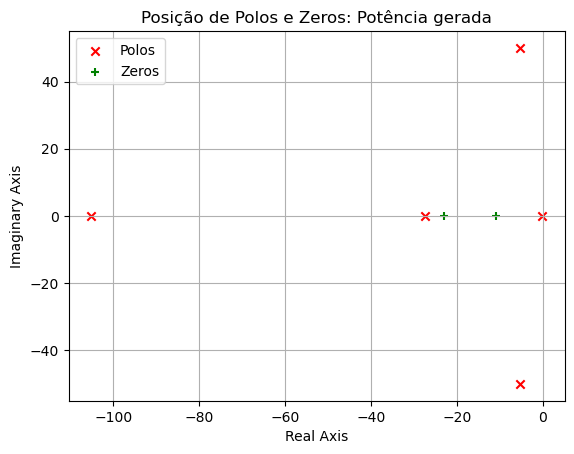

# Respostas do sistema a excitações


**Degrau**

In [ ]:
passos = 20000
tempo = 40
t = np.linspace(0, tempo, passos)

vento_linear = [1] * int(passos)
vento = [15] * int(passos)
beta = [0] * int(passos)

In [ ]:
yp = nonl_sys.output(0,xp,u=[14,0])

In [ ]:
resp_degrau = ct.input_output_response(nonl_sys,t, U = [vento,beta], X0=xp)

resplin_degrau = ct.input_output_response(lin,t, U = [vento_linear,beta], X0=[0,0,0,0,0])

In [ ]:
vars = {"Torque aerodinâmico": ["N.m",0],
        "Torque no gerador":   ["N.m",1],
        "Vel. de Rotação do rotor": ["rad/s",2],
        "Vel. de Rotação do gerador": ["rad/s",3],
        "Corrente Direta": ["A",4],
        "Corrente de Quadratura": ["A",5],
        "Potência gerada": ["w",6]}

In [ ]:
def plot(resposta_nlinear,resposta_linear,var,dict,type,yp,dgs):
    plt.figure(figsize=(8,6))
    plt.title("Comparação entre resposta {}: {} \n Linearizado x Não linear".format(type,var))
    plt.xlabel("Tempo (s)")
    plt.grid()
    plt.ylim(ymin = 0, ymax = max(abs(resposta_linear[1][dict[var][1]] + yp[dict[var][1]])) * 1.05)
    plt.ylabel("{} ({})".format(var,dict[var][0]))
    plt.plot(resposta_linear[0],resposta_linear[1][dict[var][1]] + yp[dict[var][1]], label = "Linearizado: {} {}".format(round(resposta_linear[1][dict[var][1]][-1] + yp[dict[var][1]],dgs), dict[var][0]))
    plt.plot(resposta_nlinear[0],resposta_nlinear[1][dict[var][1]] , label = "Não linear: {} {}".format(round(resposta_nlinear[1][dict[var][1]][-1],dgs), dict[var][0]))
    plt.hlines(y=yp[dict[var][1]],xmin=0,xmax=resposta_linear[0][-1],colors= 'red', label= "Ponto de operação: {} {}".format(round(yp[dict[var][1]],dgs), dict[var][0]))
    plt.legend(loc = 'lower right')
    plt.figure(figsize=(5,4))

In [ ]:
def plot_magnified(resposta_nlinear,resposta_linear,var,dict,type,yp,dgs):
    plt.figure(figsize=(8,6))
    plt.title("Comparação entre resposta {}: {} \n Linearizado x Não linear".format(type,var))
    plt.xlabel("Tempo (s)")
    plt.grid()
    plt.ylim(ymin = min(abs(resposta_linear[1][dict[var][1]] + yp[dict[var][1]])) * 0.8, ymax = max(abs(resposta_linear[1][dict[var][1]] + yp[dict[var][1]])) * 1.05)
    plt.ylabel("{} ({})".format(var,dict[var][0]))
    plt.plot(resposta_linear[0],resposta_linear[1][dict[var][1]] + yp[dict[var][1]], label = "Linearizado: {} {}".format(round(resposta_linear[1][dict[var][1]][-1] + yp[dict[var][1]],dgs), dict[var][0]))
    plt.plot(resposta_nlinear[0],resposta_nlinear[1][dict[var][1]] , label = "Não linear: {} {}".format(round(resposta_nlinear[1][dict[var][1]][-1],dgs), dict[var][0]))
    plt.hlines(y=yp[dict[var][1]],xmin=0,xmax=resposta_linear[0][-1],colors= 'red', label= "Ponto de operação: {} {}".format(round(yp[dict[var][1]],dgs), dict[var][0]))
    plt.legend(loc = 'lower right')
    plt.figure(figsize=(5,4))

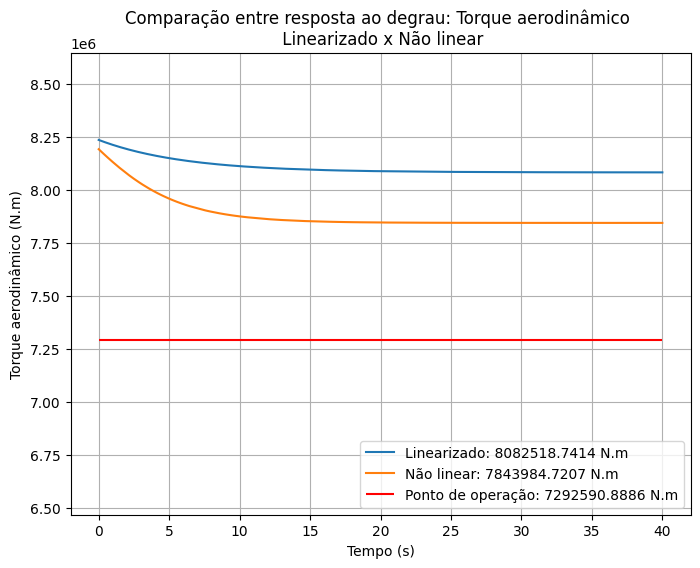

<Figure size 500x400 with 0 Axes>

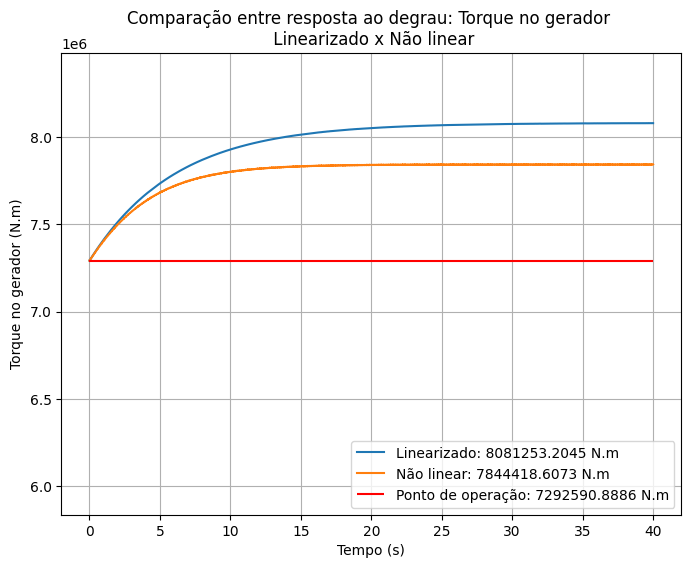

<Figure size 500x400 with 0 Axes>

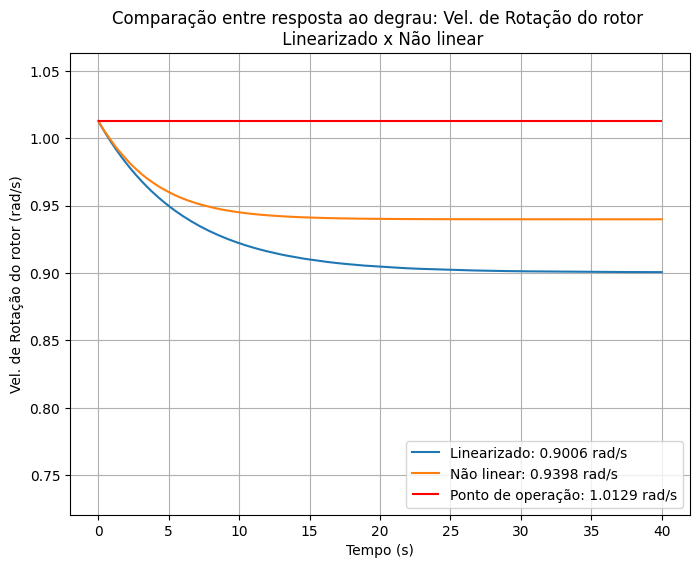

<Figure size 500x400 with 0 Axes>

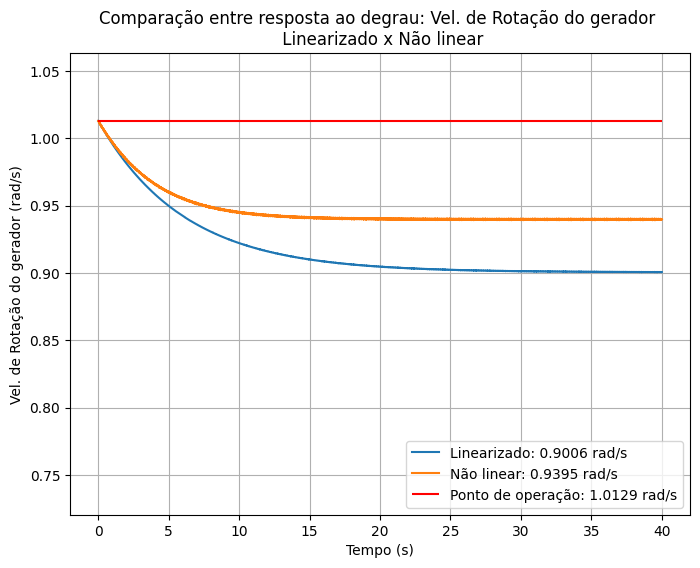

<Figure size 500x400 with 0 Axes>

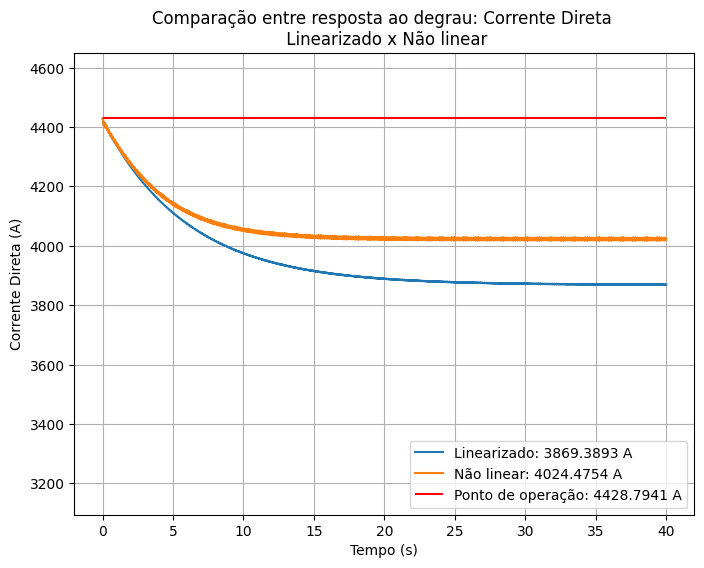

<Figure size 500x400 with 0 Axes>

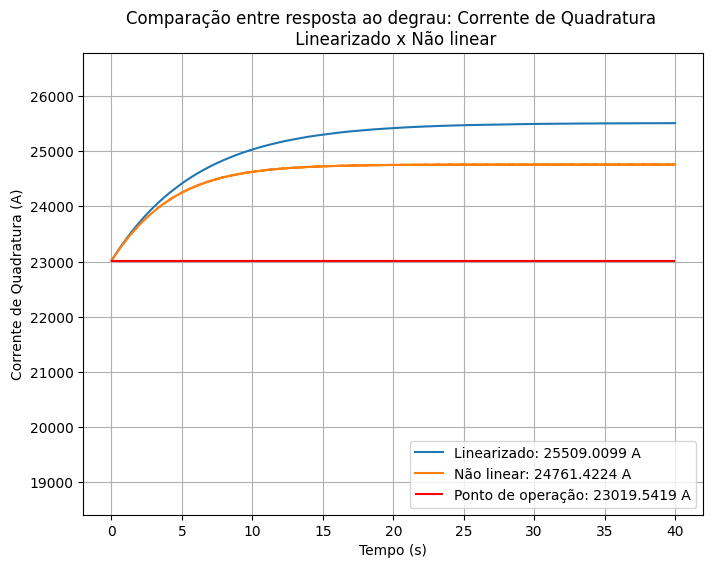

<Figure size 500x400 with 0 Axes>

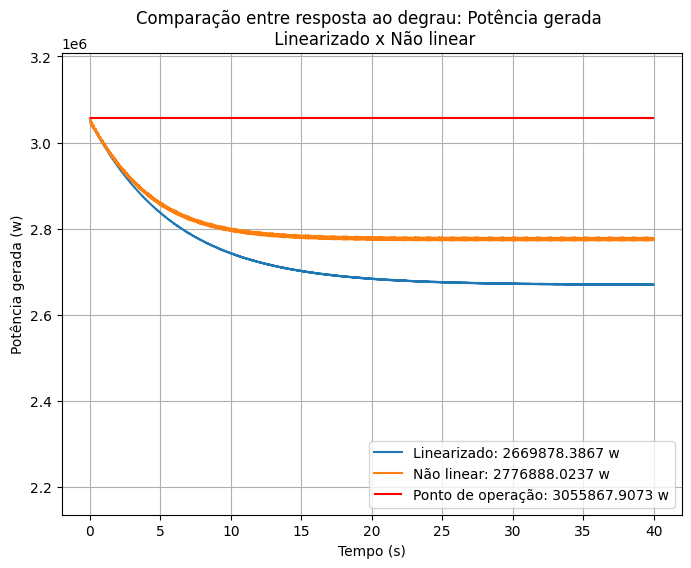

<Figure size 500x400 with 0 Axes>

In [ ]:
for i in vars:
    plot_magnified(resp_degrau,resplin_degrau,i,vars,"ao degrau",yp,4)

**RAMPA**

In [ ]:
passos = 20000
tempo = 40
t = np.linspace(0, tempo, passos)

rampa = np.linspace(0,2,5000)
vento_linear = np.append(rampa,[2] * int(passos - 5000))
vento = vento_linear + 14

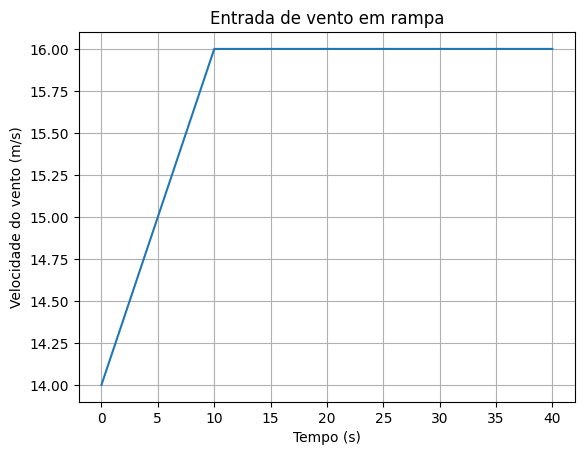

In [ ]:
plt.plot(t,vento)
plt.xlabel("Tempo (s)")
plt.ylabel("Velocidade do vento (m/s)")
plt.title("Entrada de vento em rampa")
plt.grid()

In [ ]:
resp_rampa = ct.input_output_response(nonl_sys,t, U = [vento,beta], X0=xp)

resplin_rampa = ct.input_output_response(lin,t, U = [vento_linear,beta], X0=[0,0,0,0,0])

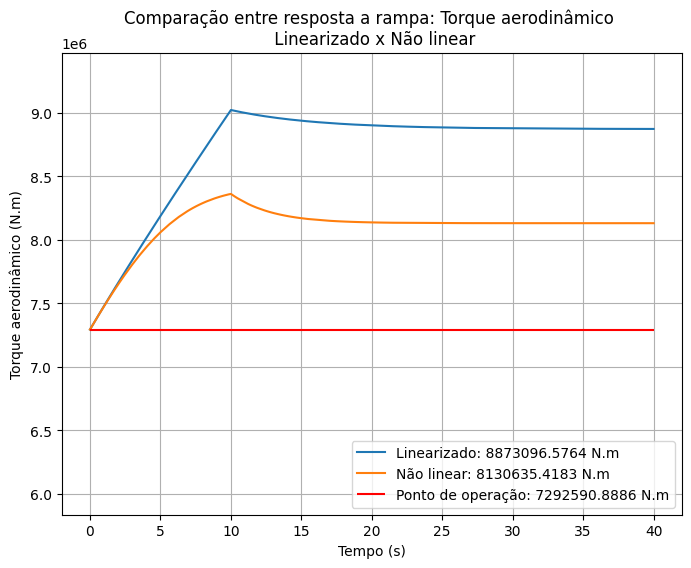

<Figure size 500x400 with 0 Axes>

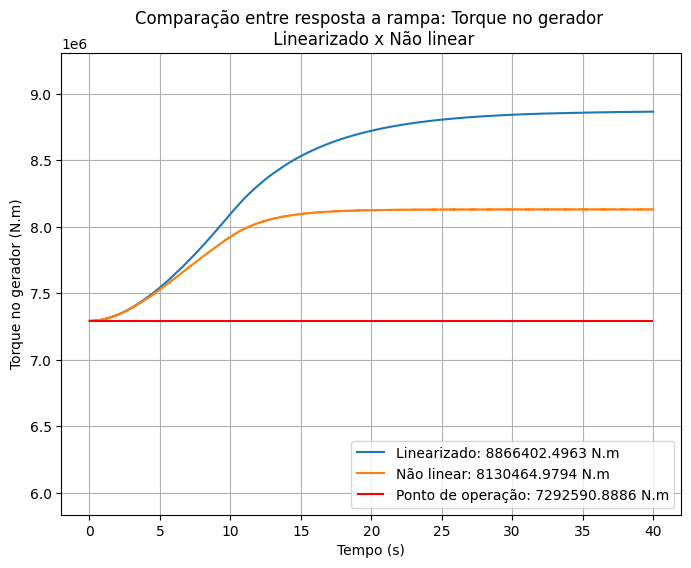

<Figure size 500x400 with 0 Axes>

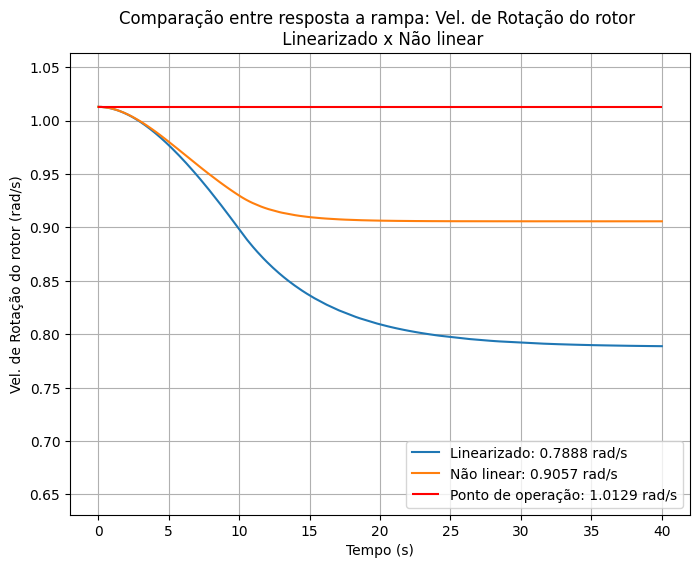

<Figure size 500x400 with 0 Axes>

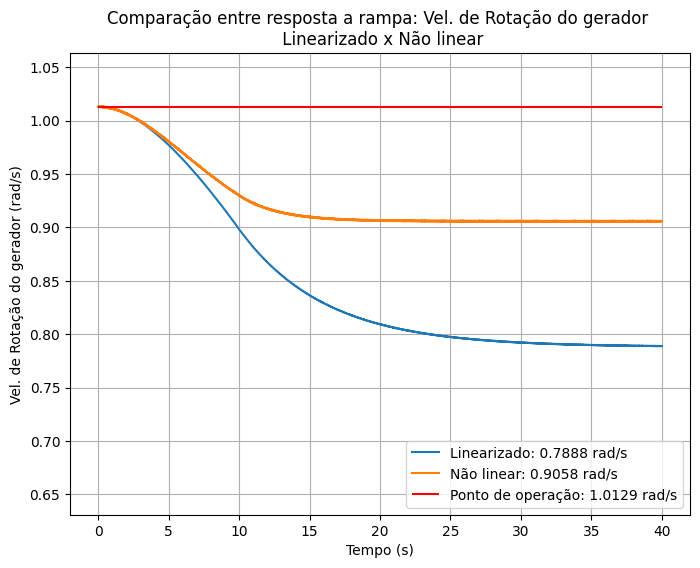

<Figure size 500x400 with 0 Axes>

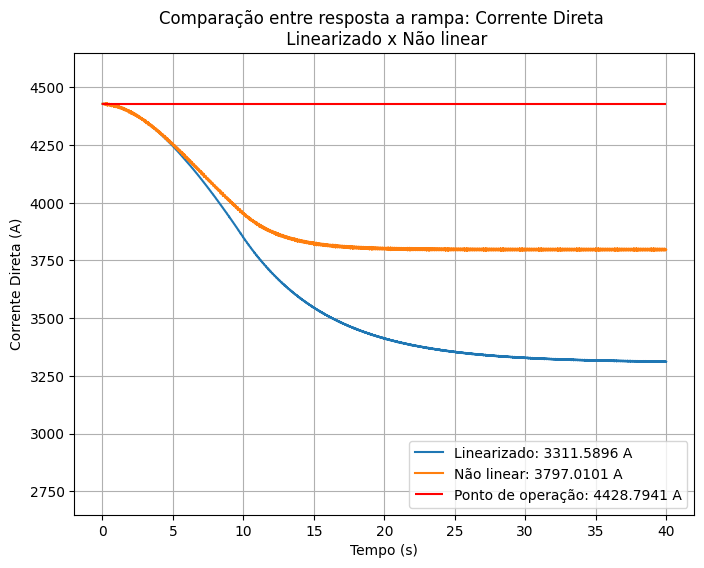

<Figure size 500x400 with 0 Axes>

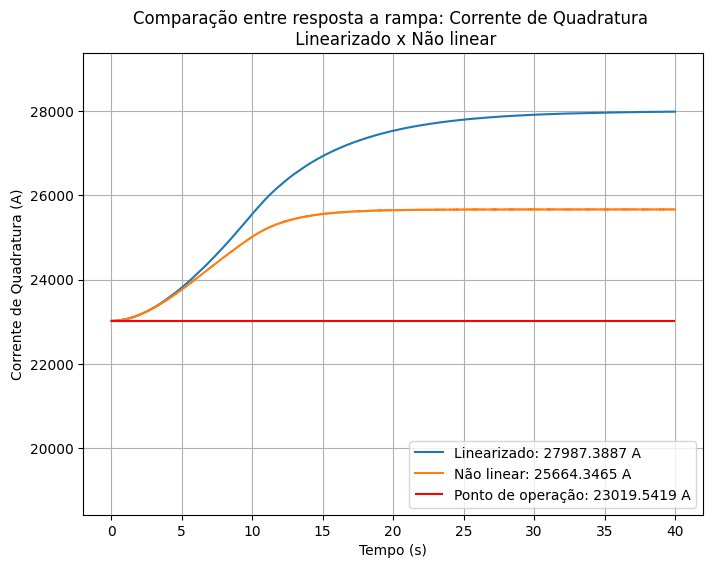

<Figure size 500x400 with 0 Axes>

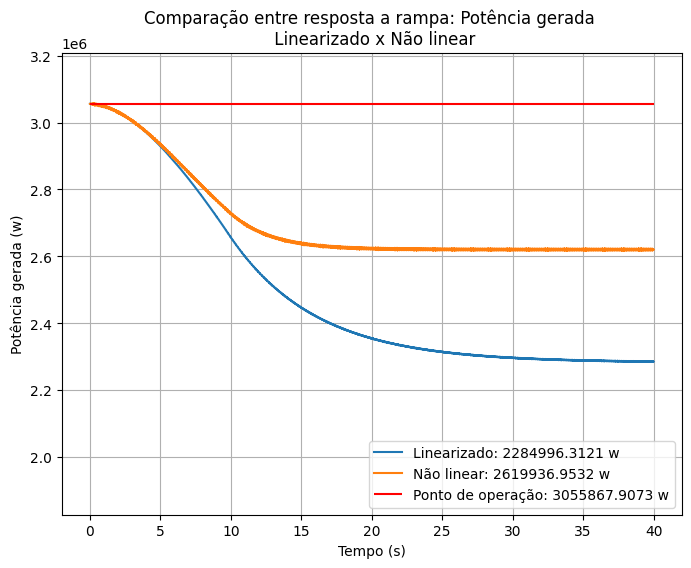

<Figure size 500x400 with 0 Axes>

In [ ]:
for i in vars:
    plot_magnified(resp_rampa,resplin_rampa,i,vars,"a rampa",yp,4)

**RAJADA DE VENTO**

In [ ]:
passos = 20000
tempo = 40
t = np.linspace(0, tempo, passos)

rajada = (1 - np.cos(2 * np.pi * t/10))[:5000] * 2
rajadaparcial = np.append([0] * int(1000), rajada)
vento_linear = np.append(rajadaparcial, [0] * 14000)
vento = vento_linear + 14

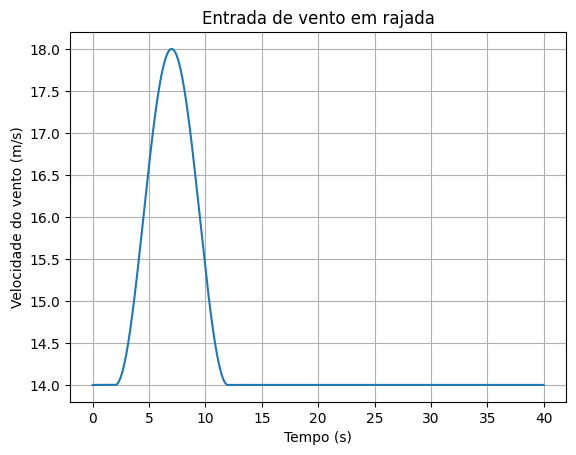

In [ ]:
plt.plot(t,vento)
plt.xlabel("Tempo (s)")
plt.ylabel("Velocidade do vento (m/s)")
plt.title("Entrada de vento em rajada")
plt.grid()

In [ ]:
resp_rajada = ct.input_output_response(nonl_sys,t, U = [vento,beta], X0=xp)

resplin_rajada = ct.input_output_response(lin,t, U = [vento_linear,beta], X0=[0,0,0,0,0])

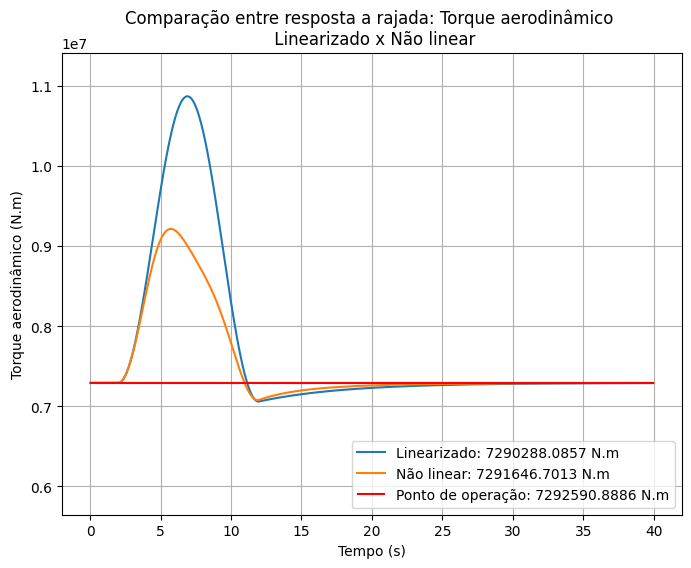

<Figure size 500x400 with 0 Axes>

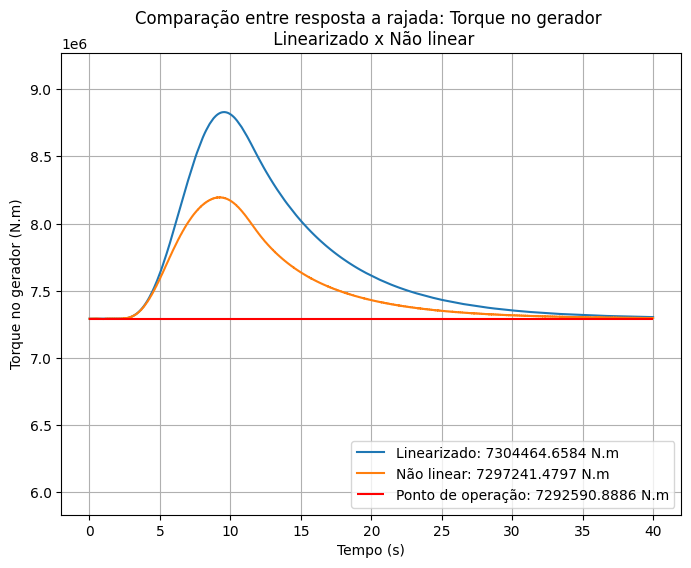

<Figure size 500x400 with 0 Axes>

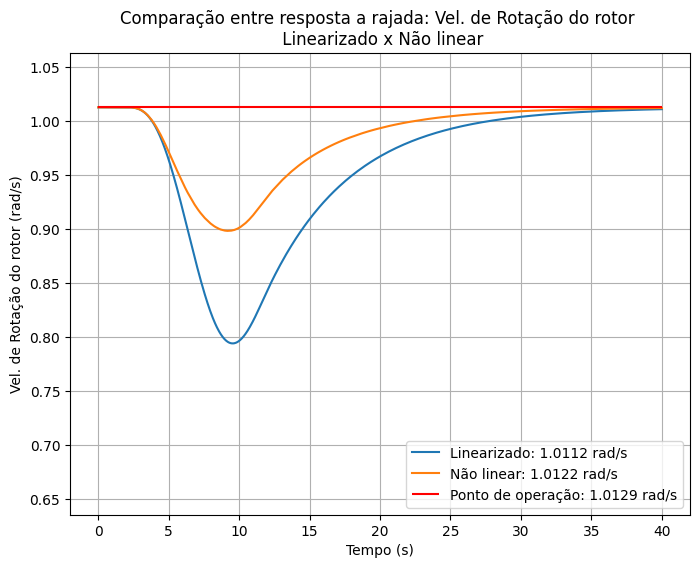

<Figure size 500x400 with 0 Axes>

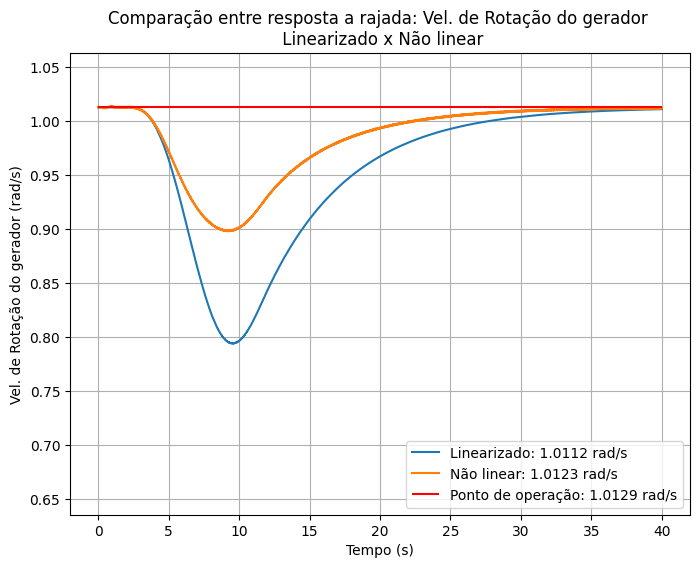

<Figure size 500x400 with 0 Axes>

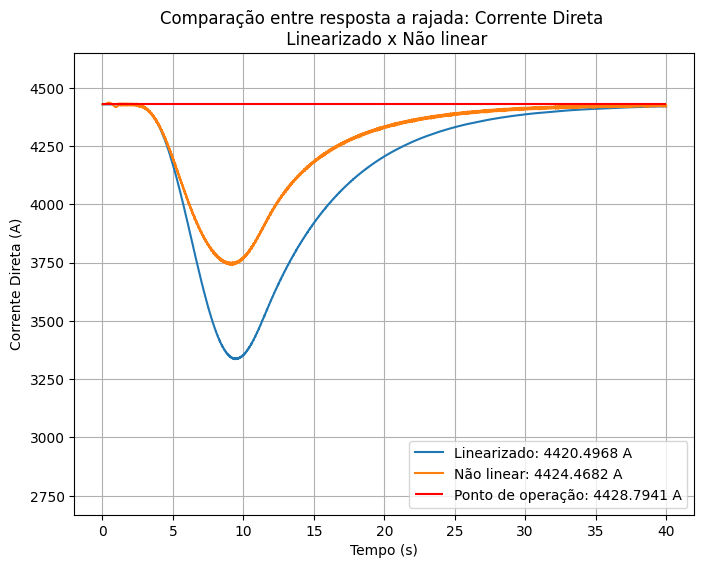

<Figure size 500x400 with 0 Axes>

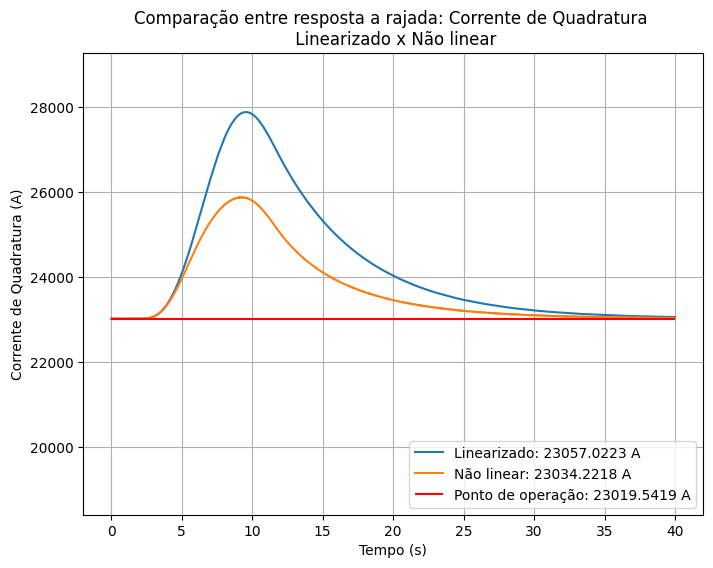

<Figure size 500x400 with 0 Axes>

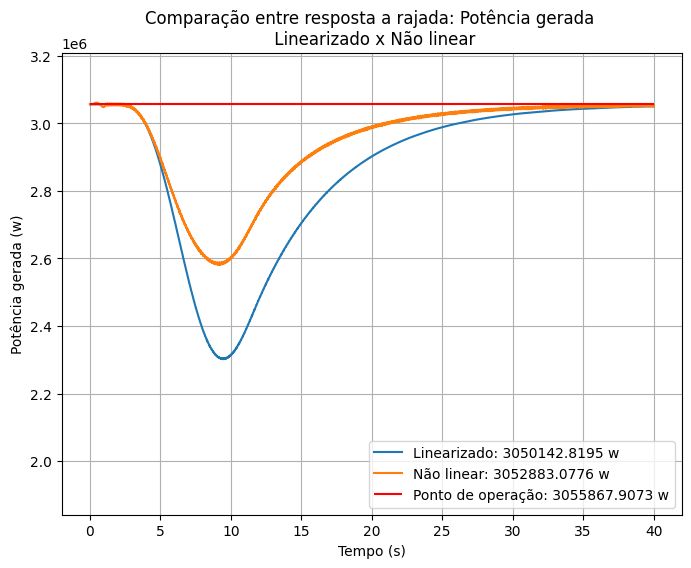

<Figure size 500x400 with 0 Axes>

In [ ]:
for i in vars:
    plot_magnified(resp_rajada,resplin_rajada,i,vars,"a rajada",yp,4)

In [ ]:
yp # outputs no ponto de operação

array([7.29259089e+06, 7.29259089e+06, 1.01285277e+00, 1.01285277e+00,
       4.42879407e+03, 2.30195419e+04, 3.05586791e+06])